In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)


Mounted at /content/drive


In [3]:
cd ..

/


In [4]:
!cp '/content/drive/MyDrive/m30000.zip' content

In [5]:
 cd content

/content


In [6]:
!unzip m30000.zip -d m30000

Streaming output truncated to the last 5000 lines.
  inflating: m30000/m30000/Wheat Loose Smut/81583c1e-f2a7-431a-838f-835e5c058863.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/81597238-5614-4213-8c43-76146d54c837.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/815c4f82-8608-42de-98fb-a0aa16ab2651.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/81621f5e-0151-41c7-bdaf-8c5f631f83fc.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/816c6f44-3843-4d8e-b9f1-b4691df336bc.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/81904737-e703-4ac5-bbc9-b8fe57b8611b.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/81986785-37c7-4ed4-b4ef-14e904e7cc28.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/8217d704-f47d-4551-962c-c1e2f409116b.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/8229fb99-69aa-40ae-b80e-061aabab6de2.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/824a6212-c85f-4904-a815-90a29d42a3b2.jpg  
  inflating: m30000/m30000/Wheat Loose Smut/828dde6c-5714-4db9-a302-ce8d0828829

In [7]:
cd m30000

/content/m30000


In [8]:
directory="m30000"
import tensorflow as tf
dataset=tf.keras.utils.image_dataset_from_directory(
    directory,
    shuffle= True,
    batch_size=32,
    image_size=(256, 256),

)

Found 24593 files belonging to 8 classes.


In [9]:
def get_dataset_partition(ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):



    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)  # Fixed variable name

    train_ds = ds.take(train_size)
    test_ds = ds.skip(train_size).take(int(test_split * ds_size))
    val_ds = ds.skip(train_size + int(test_split * ds_size)).take(val_size)

    return train_ds, test_ds, val_ds


In [10]:
train_ds, test_ds, val_ds=get_dataset_partition(dataset)

In [11]:
print(len(train_ds)*32,len(test_ds)*32,len(val_ds)*32)

17216 4896 2432


In [12]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras import layers, Model

# Define constants
IMAGE_SIZE = 256  # VGG19 input size
BATCH_SIZE = 32
n_classes = 8

# Load the pre-trained VGG19 model (excluding the top classification layer)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze the weights of the base model
base_model.trainable = False

# Add your custom classification head
x = layers.GlobalAveragePooling2D()(base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
# model.summary()


80134624/80134624 [==============================] - 3s 0us/step


In [14]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=101
)

Epoch 1/101
538/538 [==============================] - 61s 80ms/step - loss: 1.2659 - accuracy: 0.5943 - val_loss: 0.5943 - val_accuracy: 0.8084
Epoch 2/101
538/538 [==============================] - 37s 68ms/step - loss: 0.7152 - accuracy: 0.7434 - val_loss: 0.4516 - val_accuracy: 0.8553
Epoch 3/101
538/538 [==============================] - 37s 69ms/step - loss: 0.5874 - accuracy: 0.7932 - val_loss: 0.3491 - val_accuracy: 0.8845
Epoch 4/101
538/538 [==============================] - 37s 69ms/step - loss: 0.5123 - accuracy: 0.8156 - val_loss: 0.3002 - val_accuracy: 0.9054
Epoch 5/101
538/538 [==============================] - 37s 69ms/step - loss: 0.4516 - accuracy: 0.8392 - val_loss: 0.2689 - val_accuracy: 0.9141
Epoch 6/101
538/538 [==============================] - 37s 69ms/step - loss: 0.4096 - accuracy: 0.8549 - val_loss: 0.2448 - val_accuracy: 0.9219
Epoch 7/101
538/538 [==============================] - 37s 69ms/step - loss: 0.3779 - accuracy: 0.8647 - val_loss: 0.2284 - val_ac

In [15]:
model.save('vggmax.h5')

In [2]:
from tensorflow.keras.models import load_model

In [10]:
model = load_model('/content/drive/MyDrive/vggmax.h5')

In [16]:
tf.keras.backend.clear_session()
del train_ds
del val_ds

In [17]:
import gc
gc.collect()

130

In [18]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
scores=model.evaluate(test_ds)
scores

153/153 [==============================] - 15s 60ms/step - loss: 0.0876 - accuracy: 0.9808


[0.08756610751152039, 0.9808006286621094]

In [20]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
import matplotlib.pyplot as plt
import math

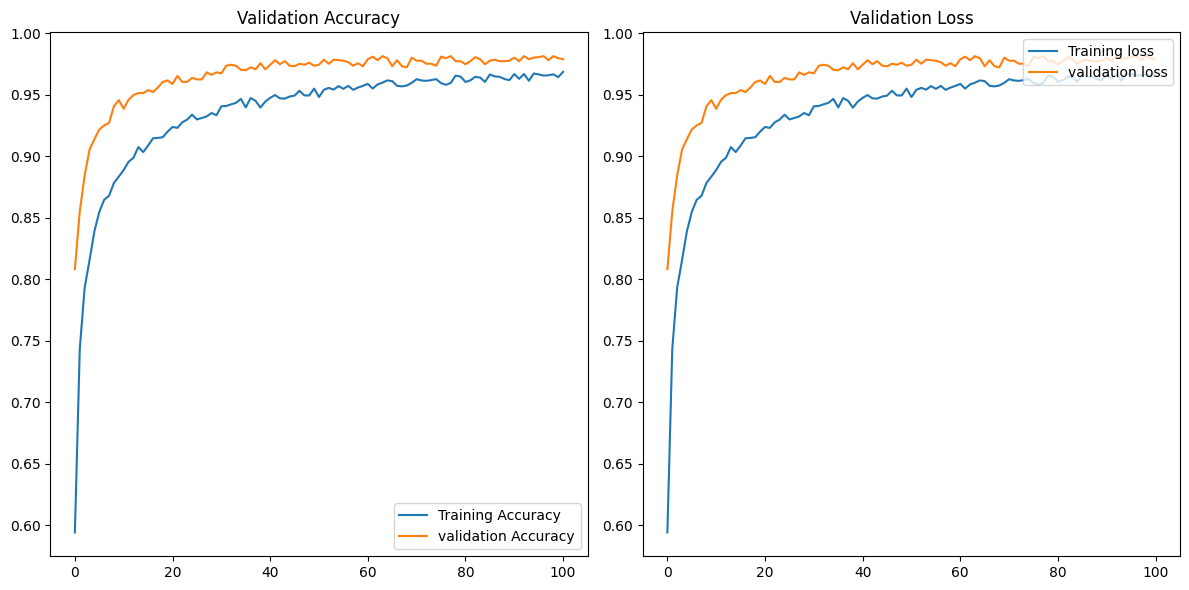

In [22]:
EPOCHS=101
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training')

plt.subplot(1,2,1)
plt.plot(range(EPOCHS),val_acc,label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),acc,label='Training loss')
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),val_acc,label='validation loss')
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.tight_layout()
plt.show()

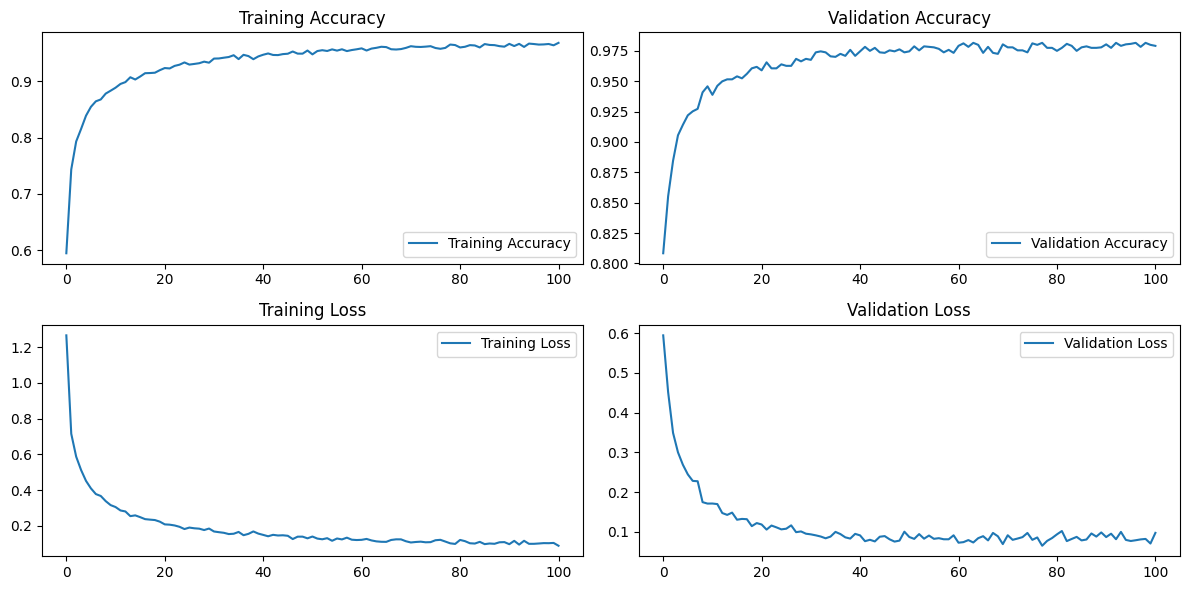

In [23]:
EPOCHS=101
plt.figure(figsize=(12,6))

plt.subplot(2,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(2,2,2)
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

plt.subplot(2,2,3)
plt.plot(range(EPOCHS), loss, label='Training Loss')  # Changed to 'loss'
plt.legend(loc='upper right')
plt.title('Training Loss')

plt.subplot(2,2,4)
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')  # Changed to 'val_loss'
plt.legend(loc='upper right')
plt.title('Validation Loss')

plt.tight_layout()
plt.show()


In [26]:
import matplotlib.pyplot as plt
class_names=dataset.class_names
class_names

['Black chaff',
 'Brown rust',
 'Crown and Root Rot',
 'Healthy Wheat',
 'Leaf Rust',
 'Powdery mildew',
 'Wheat Loose Smut',
 'Yellow rust']

first image to predict
label:  Leaf Rust
1/1 [==============================] - 0s 43ms/step
predicted Label:  Leaf Rust


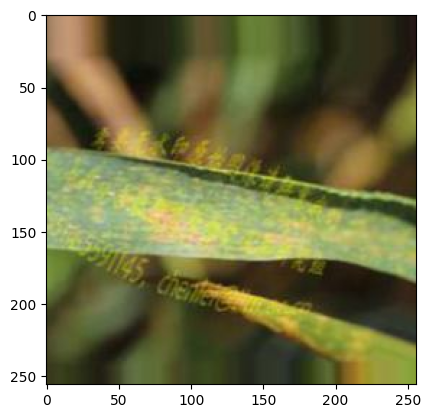

In [28]:
i=5
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

  first_image=images_batch[i].numpy().astype("uint8")

  print("first image to predict")
  plt.imshow(first_image)

  print("label: ", class_names[labels_batch[i].numpy()])
  batch_prediction=model.predict(images_batch)
  print("predicted Label: ",class_names[np.argmax(batch_prediction[i])])

In [29]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)

  predictions=model.predict(img_array)
  predicted_class= class_names[np.argmax(predictions[0])]
  confidence=round(100*np.max(predictions[0]),2)
  return predicted_class,confidence

1/1 [==============================] - 0s 21ms/step


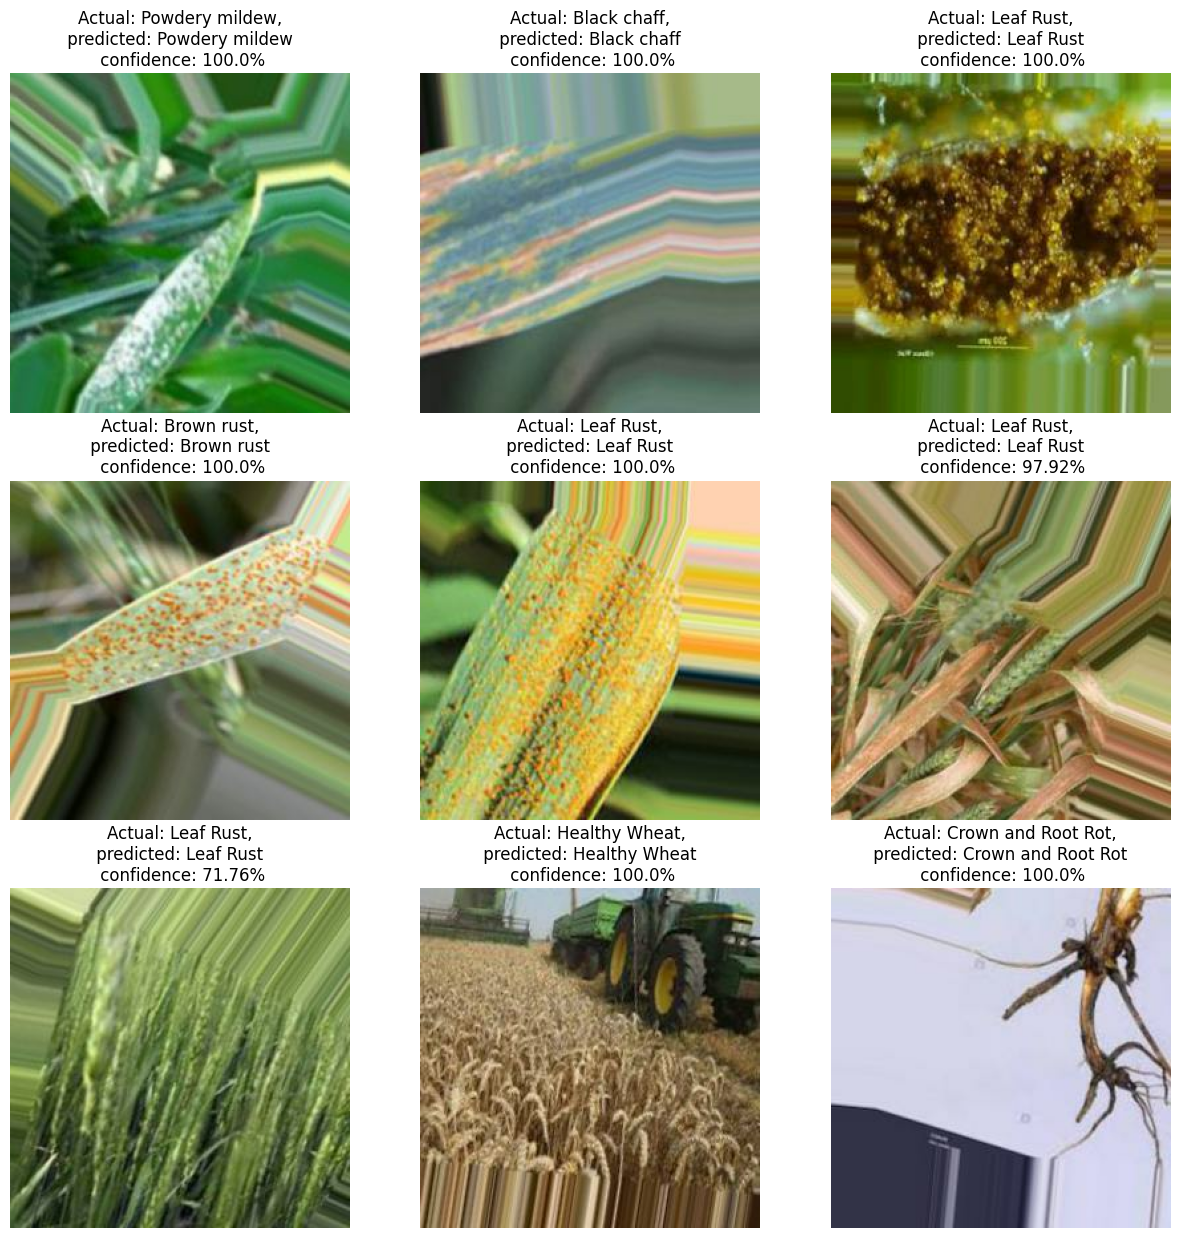

In [30]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):

  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_class,confidence=predict(model,images[i].numpy())

    actual_class=class_names[labels[i]]
    plt.title(f"Actual: {actual_class},\n predicted: {predicted_class} \n confidence: {confidence}%")
    plt.axis("off")